Tugas

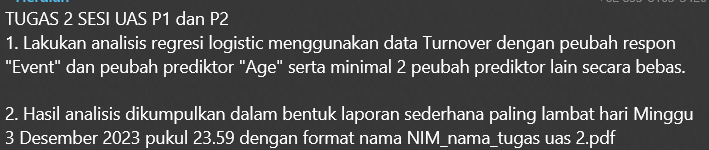

In [2]:
import sys
sys.version #Python version

'3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]'

In [3]:

#Load modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use("bmh")

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import category_encoders as ce

from IPython.display import clear_output

from factor_analyzer import FactorAnalyzer

## Exploration

In [4]:
#get data
df=pd.read_csv("Data/Raw_Data.csv", encoding = "ISO-8859-1")
target_names=["Yes", "N0"]
for i, j in zip(df["event (Y)"].unique(), target_names):
    df["event (Y)"][df["event (Y)"]==i]=j
df.isna().sum() #check for missing value
df.dtypes       #check for each columns type
df.describe()   #summary of the dataframe


metadata=pd.read_csv("Data/Metadata.csv")
temp=pd.DataFrame(df.dtypes.values, columns=["Object Type"])
metadata=pd.concat((metadata, temp), axis=1)
metadata    #turnover tuh layoff kan?

C:\Users\Rhey\AppData\Local\Temp\ipykernel_4476\851570196.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["event (Y)"][df["event (Y)"]==i]=j


,Peubah,Keterangan,Object Type
0,event (Y),Kejadian Turnover,object
1,gender,Jenis Kelamin,object
2,age,Usia,float64
3,industry,Bidang Pekerjaan,object
4,profession,Profesi,object
5,greywage,Membayar Pajak/Tidak,object
6,way,Transportasi ke Kantor,object


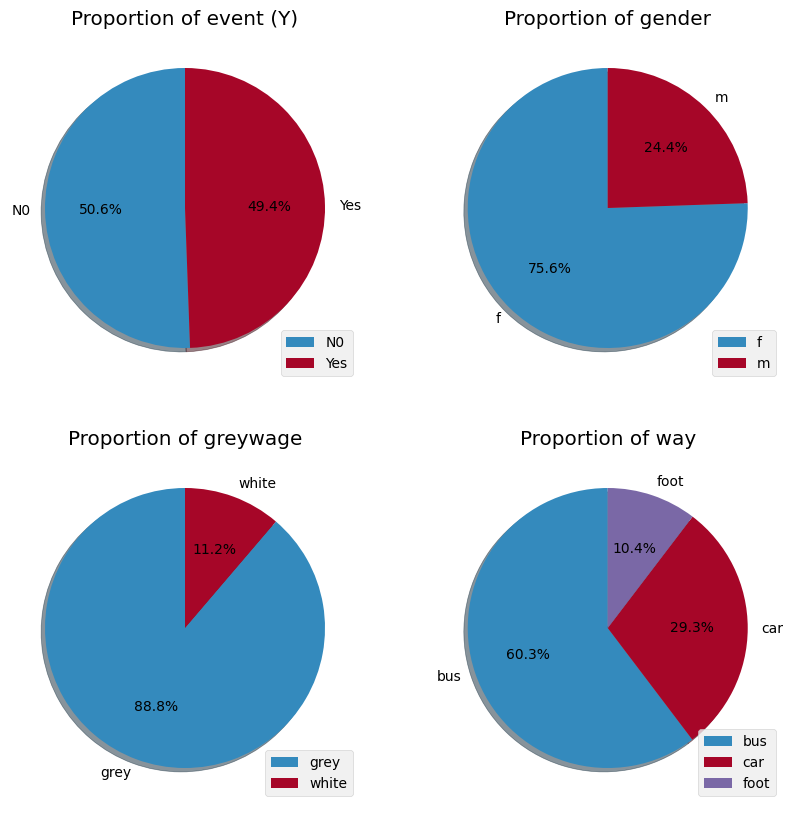

In [5]:
#get proportion of each features

fig=plt.figure(figsize=(10,10))
fig.set

counter=0
for i in [i for i in df.columns if len(df[i].unique())<10]:
    counter+=1
    ax=fig.add_subplot(2,2,counter)
    ax.pie(df[i].value_counts().values,  labels= np.unique(df[i].values), autopct='%1.1f%%', shadow={'ox': -0.04, 'edgecolor': 'none', 'shade': 0.9}, startangle=90)
    ax.set_title(f'Proportion of {i}')
    ax.legend(loc="lower right")

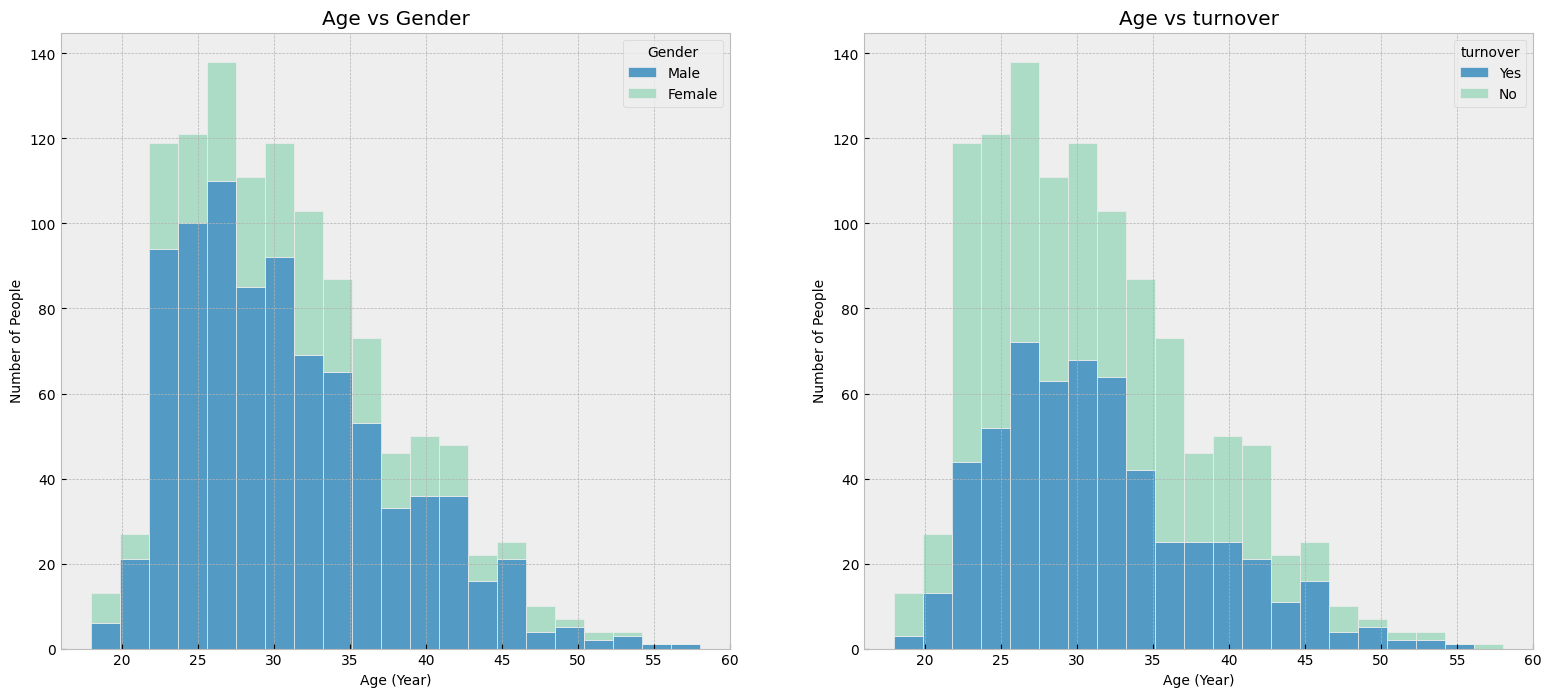

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 8))

sns.histplot(data=df, x="age", hue="gender", multiple="stack", ax=ax1, palette= 'YlGnBu')
ax1.set_title('Age vs Gender')
ax1.set_xlabel('Age (Year)')
ax1.set_ylabel('Number of People')
legend1 = ax1.legend(title="Gender", labels=["Male", "Female"])

sns.histplot(data=df, x="age", hue="event (Y)", multiple="stack", ax=ax2, palette= 'YlGnBu')
ax2.set_title('Age vs turnover')
ax2.set_xlabel('Age (Year)')
ax2.set_ylabel('Number of People')
legend2 = ax2.legend(title="turnover", labels=["Yes", "No"])


<BarContainer object of 16 artists>
<BarContainer object of 16 artists>
<BarContainer object of 15 artists>
<BarContainer object of 15 artists>


Text(0.5, 1.0, 'Probability of turnover by profession')

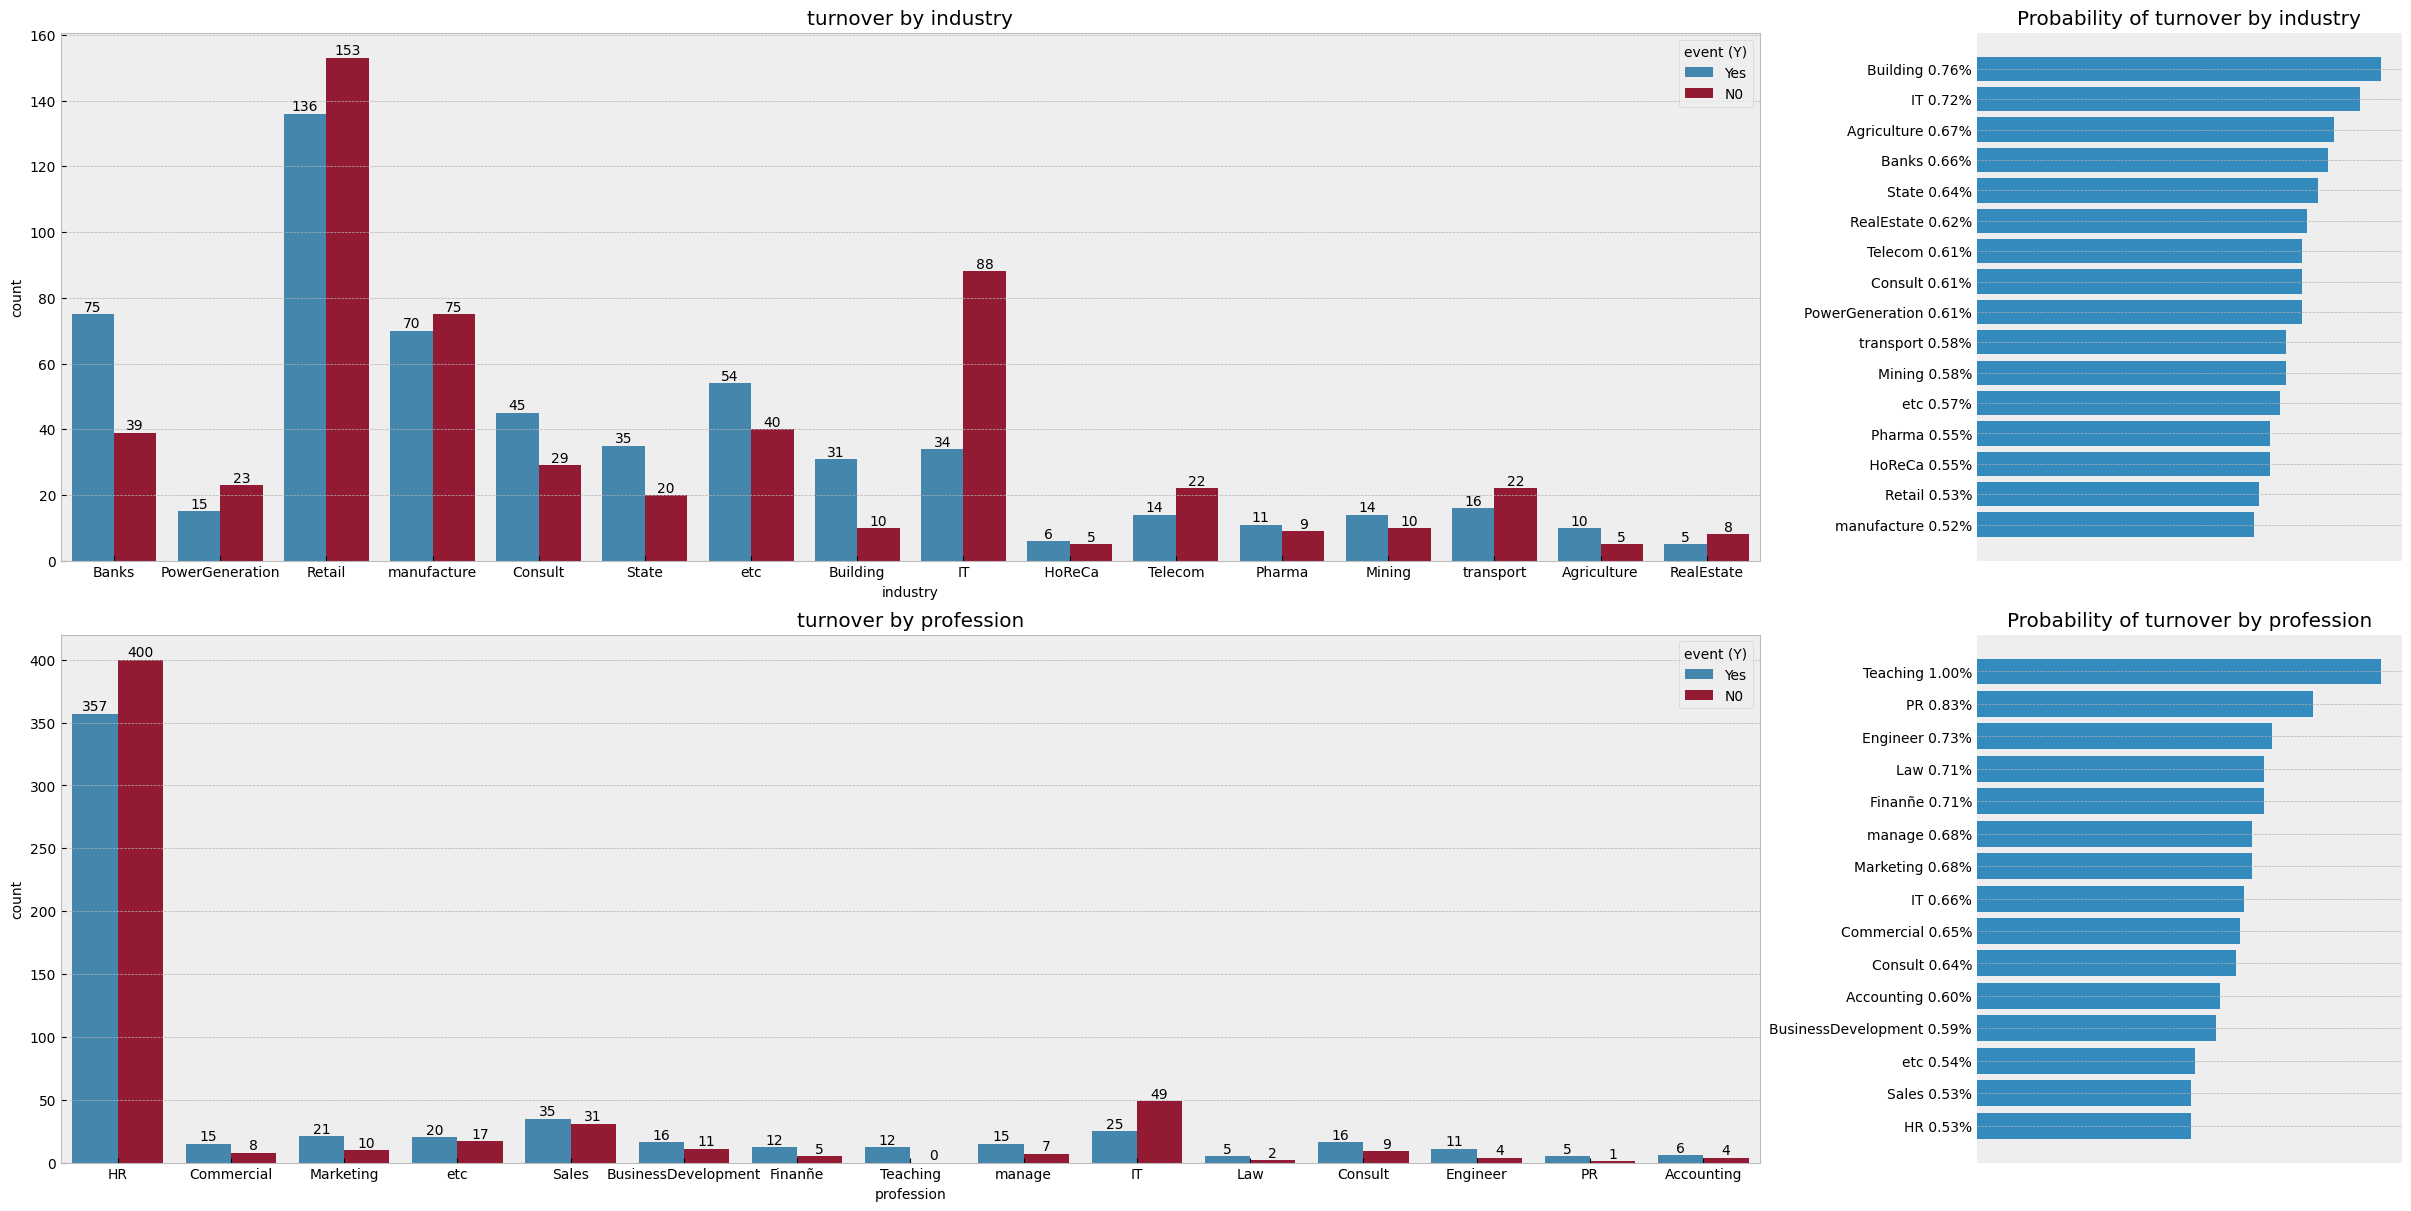

In [7]:
fig = plt.figure(constrained_layout=True, figsize=(24,12))
ax = fig.add_gridspec(2, 5)

#1st plot
ax1 = fig.add_subplot(ax[0, 0:4])
temp=df[["event (Y)", "industry"]]
bar1=sns.countplot(data=temp,x='industry',hue="event (Y)", ax=ax1)
for i in bar1.containers:
    print(i)
    bar1.bar_label(i)
ax1.set_title("turnover by industry")


#2nd plot
ax1 = fig.add_subplot(ax[0, -1])
percentage=[]
for i in df["industry"].unique():
    j= temp[temp["industry"]==i].iloc[:,0].value_counts()
    percentage.append([i, f'{j[0]/(j[0]+j[1]) : .2f}'])

percentage=np.array(sorted(percentage, key=lambda x:x[1], reverse=False))

ax1.barh(percentage[:,0], percentage[:,1].astype("float"))

ax1.set_yticks(range(len(percentage[:,0])), [f'{i}{j}%' for i,j in zip(percentage[:,0], percentage[:,1])])

for spine in ax1.spines.values():
    spine.set_visible(False)
    
ax1.axes.get_xaxis().set_visible(False)
ax1.tick_params(axis="y", left=False)

ax1.set_title('Probability of turnover by industry')


#3rd plot
ax1 = fig.add_subplot(ax[1, 0:4])
temp=df[["event (Y)", "profession"]]
bar2=sns.countplot(data=temp,x='profession',hue="event (Y)", ax=ax1)
for i in bar2.containers:
    print(i)
    bar2.bar_label(i)
ax1.set_title("turnover by profession")

#4th plot
ax1 = fig.add_subplot(ax[1, -1])
percentage=[]
for i in df["profession"].unique():
    j= temp[temp["profession"]==i].iloc[:,0].value_counts()
    try:
        percentage.append([i, f'{j[0]/(j[0]+j[1]) : .2f}'])
    except:
        percentage.append([i, f'{j[0]/(j[0]) : .2f}'])

percentage=np.array(sorted(percentage, key=lambda x:x[1], reverse=False))

ax1.barh(percentage[:,0], percentage[:,1].astype("float"))

ax1.set_yticks(range(len(percentage[:,0])), [f'{i}{j}%' for i,j in zip(percentage[:,0], percentage[:,1])])

for spine in ax1.spines.values():
    spine.set_visible(False)
    
ax1.axes.get_xaxis().set_visible(False)
ax1.tick_params(axis="y", left=False)

ax1.set_title('Probability of turnover by profession')

Text(0.5, 1.0, 'Dataframe reduced to 2 dimensions by PCA')

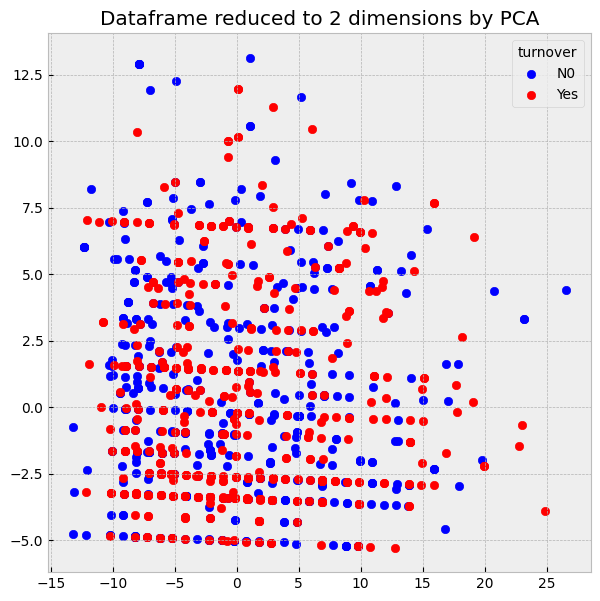

In [8]:
#PCA visualization
colour=["red", "blue"]
X=df.copy()
y=X.pop("event (Y)")
for i, j in zip(y.unique(), [1, 0]):
    y[y==i]=j

objectcolname=[i for i, j in zip(X.columns, X.dtypes) if j=="object"]

encoder=ce.OrdinalEncoder(cols=objectcolname)
X=encoder.fit_transform(X)
PCA_X=PCA(n_components=2).fit_transform(X)
clear_output()

fig, ax = plt.subplots(1,1, figsize=(7,7))
for i in [1,0]:
    ax.scatter(PCA_X[y==i,0], PCA_X[y==i,1], c=colour[i], label=target_names[i])
ax.legend(title= "turnover", loc="upper right")
ax.set_title("Dataframe reduced to 2 dimensions by PCA")

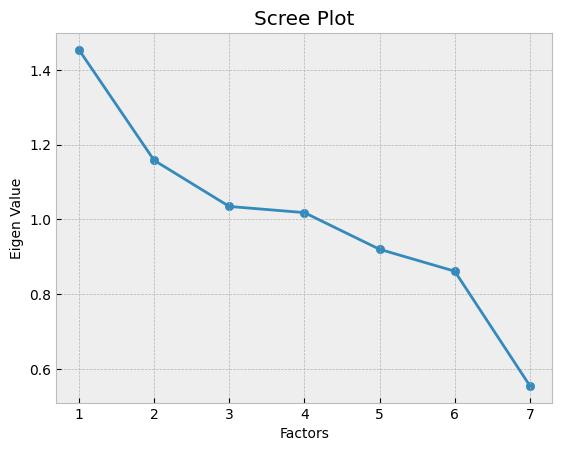

In [20]:
#Factor analysis
ordindaldf=ce.OrdinalEncoder().fit_transform(df)
fa = FactorAnalyzer(rotation = None,impute = "drop",n_factors=df.shape[1]) 
fa.fit(ordindaldf)
ev,_ = fa.get_eigenvalues()

plt.scatter(range(1,df.shape[1]+1),ev)
plt.plot(range(1,df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigen Value')
plt.grid("on")

## Pembuatan Model

In [ ]:
model=LogisticRegression()